# Quickstart of SuPy

This quickstart demonstrates the essential and simplest workflow of `supy` in SUEWS simulation:

1. [load input files](#Load-input-files)
2. [run simulation](#Run-simulations)
3. [examine results](#Examine-results)

More advanced use of `supy` are available in the [tutorials](./tutorial.rst#tutorials)

Before start, we need to load the following necessary packages.

In [24]:
import matplotlib.pyplot as plt
import supy as sp
import pandas as pd
import numpy as np
from pathlib import Path
get_ipython().run_line_magic('matplotlib', 'inline')

# produce high-quality figures, which can also be set as one of ['svg', 'pdf', 'retina', 'png']
# 'svg' produces high quality vector figures
%config InlineBackend.figure_format = 'svg'

## Load input files

### For existing SUEWS users:

First, a path to SUEWS `RunControl.nml` should be specified, which will direct `supy` to locate input files.

In [2]:
path_runcontrol = Path('../sample_run') / 'RunControl.nml'

In [3]:
df_state_init = sp.init_supy(path_runcontrol)

A sample `df_state_init` looks below (note that `.T` is used here to a nicer tableform view):

In [4]:
df_state_init.filter(like='method').T

,grid,1
var,ind_dim,
aerodynamicresistancemethod,0,2.0
emissionsmethod,0,2.0
evapmethod,0,2.0
netradiationmethod,0,3.0
roughlenheatmethod,0,2.0
roughlenmommethod,0,2.0
smdmethod,0,0.0
stabilitymethod,0,3.0
storageheatmethod,0,1.0


Following the convention of SUEWS, `supy` loads meteorological forcing (met-forcing) files at the grid level.

In [5]:
grid = df_state_init.index[0]
df_forcing = sp.load_forcing_grid(path_runcontrol, grid)

### For new users to SUEWS/SuPy:


To ease the input file preparation, a helper function `load_SampleData` is provided to get the sample input for SuPy simulations 

In [6]:
df_state_init, df_forcing = sp.load_SampleData()

### Overview of SuPy input 

#### `df_state_init`

`df_state_init` includes model Initial state consisting of:

* surface characteristics (e.g., albedo, emissivity, land cover fractions, etc.; full details refer to [SUEWS documentation](https://suews-docs.readthedocs.io/en/latest/input_files/SUEWS_SiteInfo/SUEWS_SiteInfo.html))

* model configurations (e.g., stability; full details refer to [SUEWS documentation](https://suews-docs.readthedocs.io/en/latest/input_files/RunControl/RunControl.html))

Detailed description of variables in `df_state_init` refers to [SuPy input](../data-structure/supy-io.html#df_state_init:-model-initial-states)

Surface land cover fraction information in the sample input dataset:

In [26]:
df_state_init.filter(like='sfr')

var      sfr                              
ind_dim (0,) (1,) (2,) (3,) (4,) (5,) (6,)
grid                                      
1        1.0  0.0  0.0  0.0  0.0  0.0  0.0

In [33]:
df_state_init.filter(like='method').T

,grid,1
var,ind_dim,
aerodynamicresistancemethod,0,2.0
emissionsmethod,0,2.0
evapmethod,0,2.0
netradiationmethod,0,3.0
roughlenheatmethod,0,2.0
roughlenmommethod,0,2.0
smdmethod,0,0.0
stabilitymethod,0,3.0
storageheatmethod,0,1.0


#### `df_forcing`

`df_forcing` includes meteorological and other external forcing information.

Detailed description of variables in `df_forcing` refers to [SuPy input](../data-structure/supy-io.html#supy-io.rst#df_forcing:-forcing-data).

Below is an overview of forcing variables of the sample data set used in the following simulations.

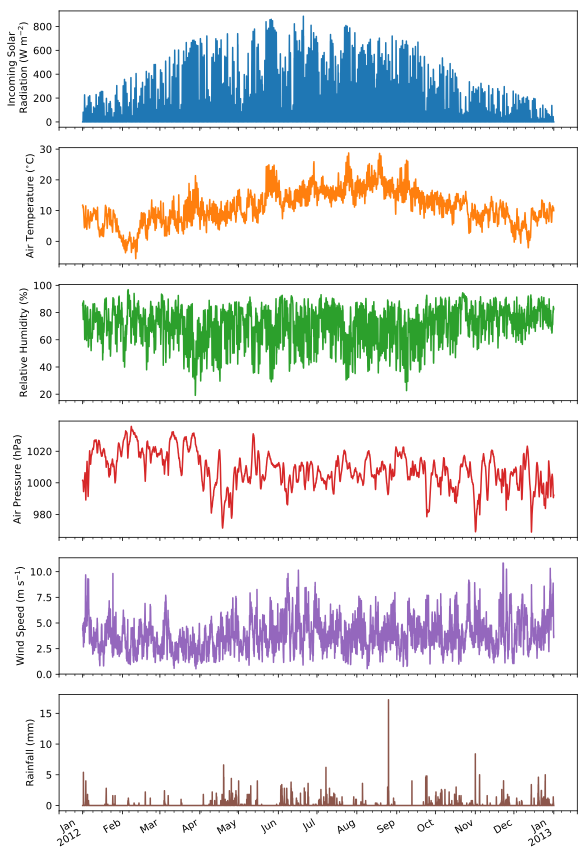

In [57]:
list_var_forcing = [
    'kdown',
    'Tair',
    'RH',
    'pres',
    'U',
    'rain',
]
dict_var_label = {
    'kdown': 'Incoming Solar\n Radiation ($ \mathrm{W \ m^{-2}}$)',
    'Tair': 'Air Temperature ($^{\circ}}$C)',
    'RH': r'Relative Humidity (%)',
    'pres': 'Air Pressure (hPa)',
    'rain': 'Rainfall (mm)',
    'U': 'Wind Speed (m $\mathrm{s^{-1}}$)'
}
df_plot_forcing_x = df_forcing.loc[:, list_var_forcing].copy().shift(
    -1).dropna(how='any')
df_plot_forcing = df_plot_forcing_x.resample('1h').mean()
df_plot_forcing['rain'] = df_plot_forcing_x['rain'].resample('1h').sum()

axes = df_plot_forcing.plot(
    subplots=True,
    figsize=(8, 12),
    legend=False,
)
fig = axes[0].figure
fig.tight_layout()
for ax, var in zip(axes, list_var_forcing):
    ax.set_ylabel(dict_var_label[var])

## Run simulations

Once met-forcing (via `df_forcing`) and initial conditions (via `df_state_init`) are loaded in, we call `sp.run_supy` to conduct a SUEWS simulation, which will return two `pandas` `DataFrame`s: `df_output` and `df_state`.

In [7]:
df_output, df_state_final = sp.run_supy(df_forcing, df_state_init)

### `df_output`

`df_output` is an ensemble output collection of major SUEWS output groups, including:

* SUEWS: the essential SUEWS output variables
* DailyState: variables of daily state information
* snow: snow output variables (effective when `snowuse = 1` set in `ser_mod_cfg`)

Detailed description of variables in `df_output` refers to [SuPy output](../data-structure/supy-io.html#df_output:-model-output-results)

In [8]:
df_output.columns.levels[0]

Index(['SUEWS', 'snow', 'DailyState'], dtype='object', name='group')

### `df_state_final`

`df_state_final` is a `DataFrame` for holding:

1. all model states if `save_state` is set to `True` when calling `sp.run_supy` and `supy` may run significantly slower for a large simulation;
2. or, only the final state if `save_state` is set to `False` (the default setting) in which mode `supy` has a similar performance as the standalone compiled SUEWS executable.

Entries in `df_state_final` have the same data structure as `df_state_init` and can thus be used for other SUEWS simulations staring at the timestamp as in `df_state_final`.

Detailed description of variables in `df_state_final` refers to [SuPy output](../data-structure/supy-io.html#df_state_final:-model-final-states)

In [9]:
df_state_final.T.head()

grid                                                  1                    
datetime                            2012-01-01 00:05:00 2013-01-01 00:05:00
var                         ind_dim                                        
aerodynamicresistancemethod 0                       2.0                 2.0
ah_min                      (0,)                   15.0                15.0
                            (1,)                   15.0                15.0
ah_slope_cooling            (0,)                    2.7                 2.7
                            (1,)                    2.7                 2.7

## Examine results

Thanks to the functionality inherited from `pandas` and other packages under the [PyData](https://pydata.org) stack, compared with the standard SUEWS simulation workflow, `supy` enables more convenient examination of SUEWS results by statistics calculation, resampling, plotting (and many more).

### Ouptut structure

`df_output` is organised with `MultiIndex` `(grid,timestamp)` and `(group,varaible)` as `index` and `columns`, respectively.

In [10]:
df_output.head()

group                        SUEWS                                             \
var                          Kdown     Kup       Ldown         Lup      Tsurf   
grid datetime                                                                   
1    2012-01-01 00:05:00  0.153333  0.0184  344.310184  372.270369  11.775916   
     2012-01-01 00:10:00  0.153333  0.0184  344.310184  372.270369  11.775916   
     2012-01-01 00:15:00  0.153333  0.0184  344.310184  372.270369  11.775916   
     2012-01-01 00:20:00  0.153333  0.0184  344.310184  372.270369  11.775916   
     2012-01-01 00:25:00  0.153333  0.0184  344.310184  372.270369  11.775916   

group                                                               ...  \
var                              QN   QF         QS         QH   QE ...   
grid datetime                                                       ...   
1    2012-01-01 00:05:00 -27.825251  0.0 -59.305405  31.480154  0.0 ...   
     2012-01-01 00:10:00 -27.825251  0.0 -59.305405  31.480154  0.0 ...   
     2012-01-01 00:15:00 -27.825251  0.0 -59.305405  31.480154  0.0 ...   
     2012-01-01 00:20:00 -27.825251  0.0 -59.305405  31.480154  0.0 ...   
     2012-01-01 00:25:00 -27.825251  0.0 -59.305405  31.480154  0.0 ...   

group                        DailyState                                \
var                      DensSnow_Paved DensSnow_Bldgs DensSnow_EveTr   
grid datetime                                                           
1    2012-01-01 00:05:00            NaN            NaN            NaN   
     2012-01-01 00:10:00            NaN            NaN            NaN   
     2012-01-01 00:15:00            NaN            NaN            NaN   
     2012-01-01 00:20:00            NaN            NaN            NaN   
     2012-01-01 00:25:00            NaN            NaN            NaN   

group                                                                  \
var                      DensSnow_DecTr DensSnow_Grass DensSnow_BSoil   
grid datetime                                                           
1    2012-01-01 00:05:00            NaN            NaN            NaN   
     2012-01-01 00:10:00            NaN            NaN            NaN   
     2012-01-01 00:15:00            NaN            NaN            NaN   
     2012-01-01 00:20:00            NaN            NaN            NaN   
     2012-01-01 00:25:00            NaN            NaN            NaN   

group                                                
var                      DensSnow_Water  a1  a2  a3  
grid datetime                                        
1    2012-01-01 00:05:00            NaN NaN NaN NaN  
     2012-01-01 00:10:00            NaN NaN NaN NaN  
     2012-01-01 00:15:00            NaN NaN NaN NaN  
     2012-01-01 00:20:00            NaN NaN NaN NaN  
     2012-01-01 00:25:00            NaN NaN NaN NaN  

[5 rows x 218 columns]

Here we demonstrate several typical scenarios for SUEWS results examination.

The essential `SUEWS` output collection is extracted as a separate variable for easier processing in the following sections. More [advanced slicing techniques](http://pandas.pydata.org/pandas-docs/stable/advanced.html#multiindex-advanced-indexing) are available in `pandas` documentation.

In [11]:
df_output_suews = df_output['SUEWS']

### Statistics Calculation

We can use `.describe()` method for a quick overview of the key surface energy balance budgets.

In [12]:
df_output_suews.loc[:, ['QN', 'QS', 'QH', 'QE', 'QF']].describe()

var,QN,QS,QH,QE,QF
count,105408.000000,105408.000000,105408.000000,105408.000000,105408.0
mean,43.081257,-1.445639,38.919791,5.607106,0.0
std,136.460171,110.329108,28.140539,11.114066,0.0
min,-85.761254,-106.005046,-47.936665,0.000000,0.0
25%,-41.721110,-70.226380,25.145524,0.000000,0.0
50%,-25.250982,-56.777049,29.060547,0.000000,0.0
75%,78.312289,27.954955,45.300129,5.963117,0.0
max,698.440633,514.869939,184.333229,129.105145,0.0


### Plotting

#### Basic example
Plotting is very straightforward via the `.plot` method bounded with `pandas.DataFrame`.
Note the usage of `loc` for to slices of the output `DataFrame`.

In [13]:
# a dict for better display variable names
dict_var_disp = {
    'QN': '$Q^*$',
    'QS': r'$\Delta Q_S$',
    'QE': '$Q_E$',
    'QH': '$Q_H$',
    'QF': '$Q_F$',
    'Kdown': r'$K_{\downarrow}$',
    'Kup': r'$K_{\uparrow}$',
    'Ldown': r'$L_{\downarrow}$',
    'Lup': r'$L_{\uparrow}$',
    'Rain': '$P$',
    'Irr': '$I$',
    'Evap': '$E$',
    'RO': '$R$',
    'TotCh': '$\Delta S$',
}

Quick look at the simulation results:

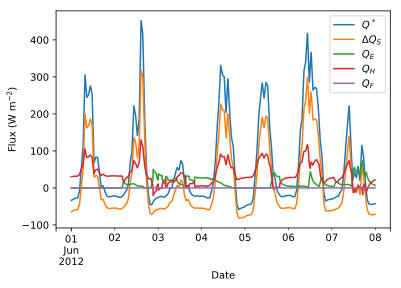

In [14]:
ax_output = df_output_suews\
    .loc[1]\
    .loc['2012 6 1':'2012 6 7',
         ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot()
ax_output.set_xlabel('Date')
ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
ax_output.legend()

#### More examples
Below is a more complete example for examination of urban energy balance over a whole year.

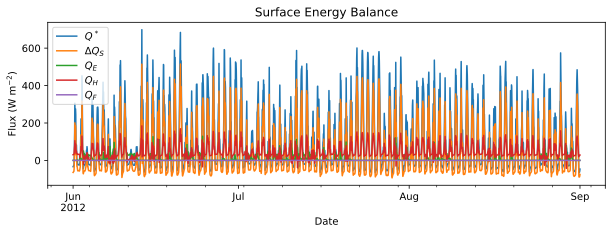

In [15]:
# energy balance
ax_output = df_output_suews.loc[1]\
    .loc['2012 6':'2012 8', ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot(
        figsize=(10, 3),
        title='Surface Energy Balance',
    )
ax_output.set_xlabel('Date')
ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
ax_output.legend()

### Resampling

The suggested runtime/simulation frequency of SUEWS is `300 s`, which usually results a large output and may be over-weighted for storage and analysis. 
Also, you may feel apparent slowdown in producing the above figure as a large amount of data were used for the plotting.
To slim down the result size for analysis and output, we can `resample` the default output very easily.

In [16]:
rsmp_1d = df_output_suews.loc[1].resample('1d')
# daily mean values
df_1d_mean = rsmp_1d.mean()
# daily sum values
df_1d_sum = rsmp_1d.sum()

We can then re-examine the above energy balance at hourly scale and plotting will be significantly faster.

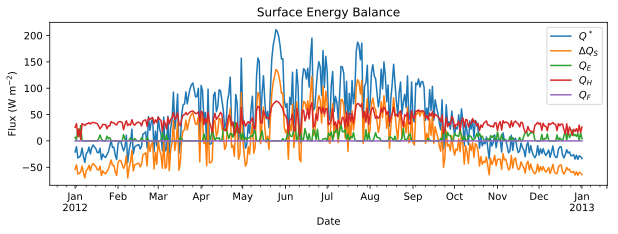

In [17]:
# energy balance
ax_output = df_1d_mean\
    .loc[:, ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot(
            figsize=(10, 3),
            title='Surface Energy Balance',
        )
ax_output.set_xlabel('Date')
ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
ax_output.legend()

Then we use the hourly results for other analyses.

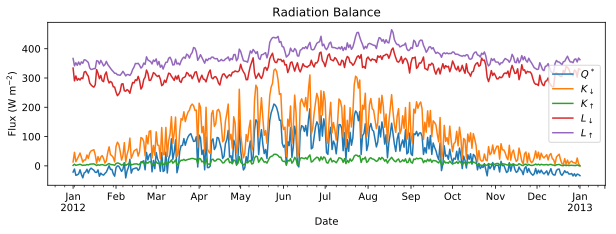

In [18]:
# radiation balance
ax_output = df_1d_mean\
    .loc[:, ['QN', 'Kdown', 'Kup', 'Ldown', 'Lup']]\
    .rename(columns=dict_var_disp)\
    .plot(
        figsize=(10, 3),
        title='Radiation Balance',
    )
ax_output.set_xlabel('Date')
ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
ax_output.legend()

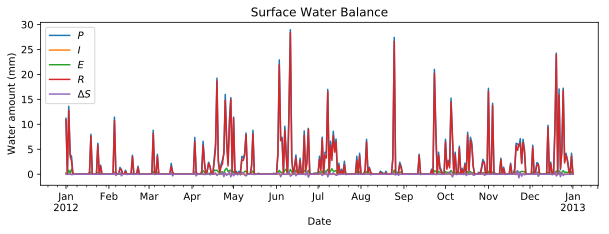

In [19]:
# water balance
ax_output = df_1d_sum\
    .loc[:, ['Rain', 'Irr', 'Evap', 'RO', 'TotCh']]\
    .rename(columns=dict_var_disp)\
    .plot(
        figsize=(10, 3),
        title='Surface Water Balance',
    )
ax_output.set_xlabel('Date')
ax_output.set_ylabel('Water amount (mm)')
ax_output.legend()

Get an overview of partitioning in energy and water balance at monthly scales:

In [20]:
# get a monthly Resampler
df_plot=df_output_suews.loc[1].copy()
df_plot.index=df_plot.index.set_names('Month')
rsmp_1M = df_plot\
    .shift(-1)\
    .dropna(how='all')\
    .resample('1M', kind='period')
# mean values
df_1M_mean = rsmp_1M.mean()
# sum values
df_1M_sum = rsmp_1M.sum()


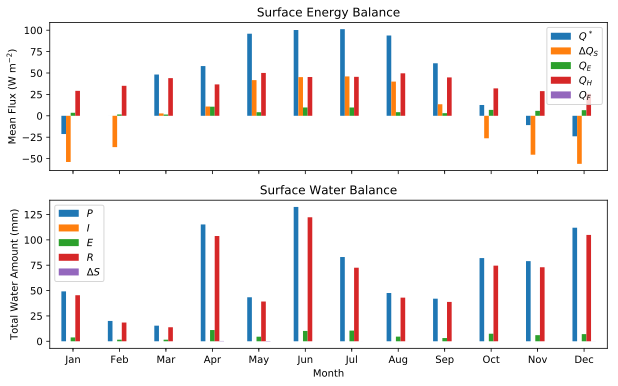

In [21]:
# month names
name_mon = [x.strftime('%b') for x in rsmp_1M.groups]
# create subplots showing two panels together
fig, axes = plt.subplots(2, 1, sharex=True)
# surface energy balance
df_1M_mean\
    .loc[:, ['QN', 'QS', 'QE', 'QH', 'QF']]\
    .rename(columns=dict_var_disp)\
    .plot(
        ax=axes[0],  # specify the axis for plotting
        figsize=(10, 6),  # specify figure size
        title='Surface Energy Balance',
        kind='bar',
    )
# surface water balance
df_1M_sum\
    .loc[:, ['Rain', 'Irr', 'Evap', 'RO', 'TotCh']]\
    .rename(columns=dict_var_disp)\
    .plot(
        ax=axes[1],  # specify the axis for plotting
        title='Surface Water Balance',
        kind='bar'
    )

# annotations
axes[0].set_ylabel('Mean Flux ($ \mathrm{W \ m^{-2}}$)')
axes[0].legend()
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Water Amount (mm)')
axes[1].xaxis.set_ticklabels(name_mon, rotation=0)
axes[1].legend()

### Output

The resampled output can be outputed for a smaller file.

In [22]:
df_1d_mean.to_csv(
    'suews_1d_mean.txt',
    sep='\t',
    float_format='%8.2f',
    na_rep=-999,
)

For a justified format, we use the `to_string` for better format controlling and write the formatted string out to a file.

In [23]:
str_out = df_1d_mean.to_string(
    float_format='%8.2f',
    na_rep='-999',
    justify='right',
)
with open('suews_sample.txt', 'w') as file_out:
    print(str_out, file=file_out)